In [6]:
#Creating the feedforward network
import torch
import pandas as pd
import os
from transformers import AutoTokenizer
from MyNN import FFNN

BERT_variant = 'navteca/roberta-base-squad2'

vocab_size = AutoTokenizer.from_pretrained(BERT_variant).vocab_size
ent_embeddings_size = len(pd.read_csv(os.path.join(os.path.join(os.path.abspath('../../UMLS_KG'), \
                                                            os.path.relpath('embeddings/distmult')), \
                                               'ent_embedding.tsv'), sep='\t', header=None).columns)

#1 X [dim of 1 KGE], since we are doing mean(triple)
input_dimension = ent_embeddings_size

#Size of BERT variant vocabulary
output_dimension = vocab_size

#Play with this
number_of_hidden_layers = 5

#Size of embedding required by BERT variant (usually 768)
hidden_dimension = 768

#Initializing the network
model = FFNN(input_dimension, output_dimension, number_of_hidden_layers, hidden_dimension)

'''
We have to make send the model to device before creating the optimizer since parameters of a model after 
.cuda() will be different objects with those before the call (https://pytorch.org/docs/stable/optim.html)
'''

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = torch.nn.MSELoss()

#Adam optimizer
optimizer = torch.optim.Adam(model.parameters())

print(f'FFN architecture: \n {model} \n Loss Function: {criterion} \n Optimizer: {optimizer}')
print(f'\n Device being used: {device}')

FFN architecture: 
 FFNN(
  (custom_nn): ModuleList(
    (Dropout0): Dropout(p=0.25, inplace=False)
    (LL0): Linear(in_features=768, out_features=768, bias=True)
    (LN0): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (activation0): ReLU()
    (Dropout1): Dropout(p=0.25, inplace=False)
    (LL1): Linear(in_features=768, out_features=768, bias=True)
    (LN1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (activation1): ReLU()
    (Dropout2): Dropout(p=0.25, inplace=False)
    (LL2): Linear(in_features=768, out_features=768, bias=True)
    (LN2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (activation2): ReLU()
    (Dropout3): Dropout(p=0.25, inplace=False)
    (LL3): Linear(in_features=768, out_features=768, bias=True)
    (LN3): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (activation3): ReLU()
    (Dropout4): Dropout(p=0.25, inplace=False)
    (LL4): Linear(in_features=768, out_features=768, bias=True)
    (LN4): LayerNorm((768,),

In [2]:
#Creating dataset object & dataloader
from torch.utils.data import Dataset, DataLoader
class FFN_Data(Dataset):
    def __init__(self):
        data = pd.read_pickle('Homogenization_data.pkl')
        self.x = data['train']
        self.y = data['test']
        self.n_samples = data.shape[0]
    
    def __getitem__(self, index):
        true_output = np.zeros(vocab_size)
        np.put(true_output, self.y[index], 1) #Creating true target representation here
        return self.x[index], true_output
    
    def __len__(self):
        return self.n_samples

homogenization_dataset = FFN_Data()
dataloader = DataLoader(dataset=homogenization_dataset, batch_size=4, shuffle=True, num_workers=2)

print('Dataloader object created...')

Dataloader object created...


In [7]:
#Training Loop
import numpy as np

num_epochs = 2
num_iterations = np.ceil(len(homogenization_dataset)/dataloader.batch_size)

#Setting model to train mode
model.train()
epoch_loss_list = []
for epoch in range(num_epochs):
    epoch_loss = 0
    for iteration_num, (train_sample, true_output) in enumerate(dataloader):

        #Clearing Gradients
        optimizer.zero_grad()
        
        #Generating Predictions
        #'_' for hidden_states[-3] since we don't need that for training
        softmax_output, _ = model(train_sample.to(device))       
               
        #Compute Loss
        loss = criterion(softmax_output.double().to(device), true_output.double().to(device))

        #Backward pass
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        if (iteration_num + 1) % 5 == 0:
            print(f'Epoch: {epoch+1}/{num_epochs} | Iteration: {iteration_num+1}/{num_iterations} | \
                  Current Loss: {loss.item()}')
    
    epoch_loss_list.append(epoch_loss)
    print(f'Epoch: {epoch+1}/{num_epochs} | Epoch Loss {epoch_loss}')

print('Saving model to disk...')
torch.save(model.state_dict(), 'Homogenizer.pt')
print('Model saved...')

Epoch: 1/2 | Iteration: 5/13.0 |                   Current Loss: 0.04386048702305846
Epoch: 1/2 | Iteration: 10/13.0 |                   Current Loss: 0.018323266507670497
Epoch: 1/2 | Epoch Loss 0.5755806309700294
Epoch: 2/2 | Iteration: 5/13.0 |                   Current Loss: 0.008922135126687908
Epoch: 2/2 | Iteration: 10/13.0 |                   Current Loss: 0.006308296615131823
Epoch: 2/2 | Epoch Loss 0.10376871880258134
Saving model to disk...
Model saved...


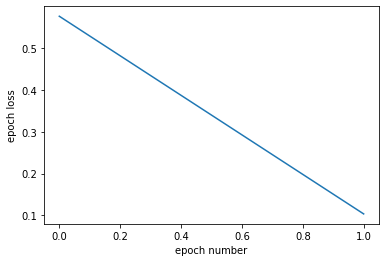

In [10]:
#Tracking epoch loss
import matplotlib.pyplot as plt
plt.plot(list(range(len(epoch_loss_list))), epoch_loss_list)
plt.xlabel('epoch number')
plt.ylabel('epoch loss')
plt.savefig('Training_Loss_Plot.png', bbox_inches='tight', dpi=600)